# Rule-Based Trading Signals for Candlestick Pattern Recognition

This notebook automates the identification of candlestick patterns and generates trading signals (`Buy`, `Sell`) by applying rule-based logic, mimicking human expertise in pattern recognition. It processes historical OHLCV data to detect patterns and visualizes these on candlestick charts.

1. **Data Acquisition**: Load and preprocess OHLCV (Open, High, Low, Close, Volume) data.
2. **Pattern Detection**: Apply rule-based logic to identify key candlestick formations.
3. **Signal Processing**: Map detected patterns to trading signals and log results.
4. **Visualization**: Overlay patterns on interactive charts for user validation.

This create a baseline comparison for the CNN model 



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os


In [17]:

class RB_Candlestick:
    def __init__(self, ticker_data):
        self.ticker_data = ticker_data
        self.morning_star_indices = []
        self.evening_star_indices = []
        self.trades = []
        self.pnl = 0

    def detect_patterns(self):
        """Detect Morning Star and Evening Star patterns dynamically."""
        for i in range(2, len(self.ticker_data)):
            first, second, third = self.ticker_data.iloc[i - 2], self.ticker_data.iloc[i - 1], self.ticker_data.iloc[i]

            # Morning Star Detection (Buy)
            if (
                first['Close'] < first['Open'] and
                abs(second['Close'] - second['Open']) < 0.3 * (second['High'] - second['Low']) and
                third['Close'] > third['Open'] and
                third['Close'] > (first['Close'] + first['Open']) / 2
            ):
                self.morning_star_indices.append(i)
                self.trades.append({"Date": self.ticker_data.index[i], "Signal": "Buy", "Price": third['Close']})

            # Evening Star Detection (Sell)
            if (
                first['Close'] > first['Open'] and
                abs(second['Close'] - second['Open']) < 0.3 * (second['High'] - second['Low']) and
                third['Close'] < third['Open'] and
                third['Close'] < (first['Close'] + first['Open']) / 2
            ):
                self.evening_star_indices.append(i)
                self.trades.append({"Date": self.ticker_data.index[i], "Signal": "Sell", "Price": third['Close']})

    def get_accumulated_positions(self):
        """Helper function to calculate accumulated positions over time."""
        cumulative_positions = []
        current_position = 0

        for trade in self.trades:
            if trade["Signal"] == "Buy":
                current_position += 1
            elif trade["Signal"] == "Sell":
                current_position -= 1
            cumulative_positions.append({"Date": trade["Date"], "Position": current_position})

        #
        positions_df = pd.DataFrame(cumulative_positions).set_index("Date")
        positions_df = positions_df.resample("D").ffill().fillna(0)
        return positions_df

    def backtest(self):
        """Calculate PnL using the average price and accumulated position."""
        
        weighted_sum_price = 0  
        accumulated_position = 0 
        pnl = 0  

        # Iterate through trades to compute weighted average price and accumulated position
        for trade in self.trades:
            signal = trade["Signal"]
            price = trade["Price"]
            position = 1 if signal == "Buy" else -1  # Assign +1 for Buy and -1 for Sell

          
            weighted_sum_price += position * price
            accumulated_position += position

        # Avoid division by zero for average price calculation
        if accumulated_position != 0:
            average_price = weighted_sum_price / accumulated_position
        else:
            average_price = 0

        # Use the last close price to calculate PnL
        current_price = self.ticker_data.iloc[-1]["Close"]
        pnl = accumulated_position * (current_price - average_price)

        return round(pnl, 2)

    def plot_accumulated_positions(self):
        """Plot accumulated positions over time."""
        positions_df = self.get_accumulated_positions()

        plt.figure(figsize=(7, 5))
        plt.bar(positions_df.index, positions_df["Position"], color="blue", alpha=0.7)
        plt.axhline(0, color="black", linestyle="--")
        plt.title("Accumulated Positions Over Time")
        plt.xlabel("Date")
        plt.ylabel("Position")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def visualize(self, save_path):
        """Visualize trades over the candlestick chart."""
        fig, ax = mpf.plot(
            self.ticker_data,
            type="candle",
            style="yahoo",
            returnfig=True,
            title="Candlestick Chart with Signals",
            volume=False,
            warn_too_much_data=len(ticker_data) + 1
        )
        ax = ax[0]

        # plots
        for trade in self.trades:
            color = "green" if trade["Signal"] == "Buy" else "red"
            label = "Buy Signal" if trade["Signal"] == "Buy" else "Sell Signal"
            ax.scatter(
                self.ticker_data.index.get_loc(trade["Date"]),
                trade["Price"],
                color=color,
                label=label,
                s=50,
                alpha=0.7,
            )

        #defensive programming
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        plt.savefig(save_path)
        plt.show()


Visualizing Ticker: ^FTSE


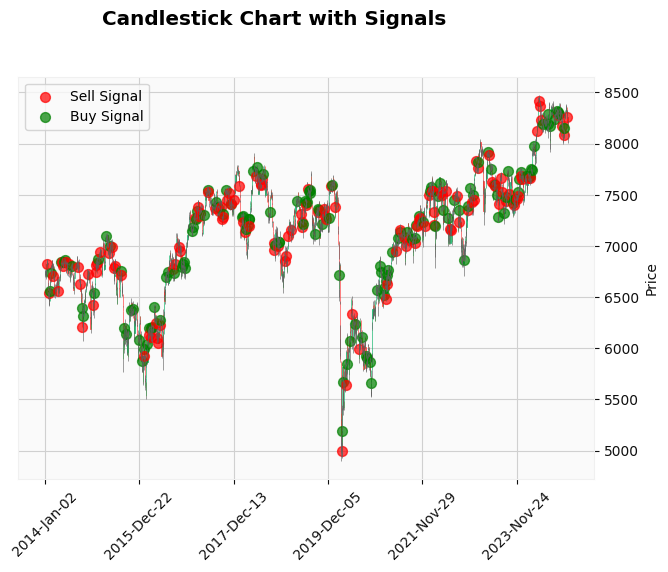

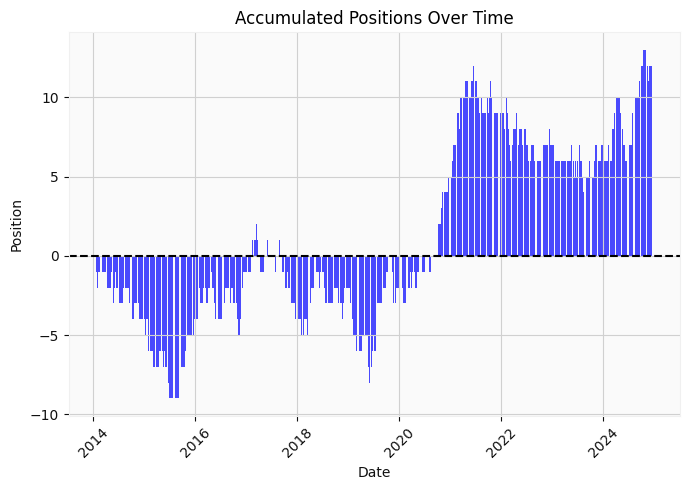


Total Accumulated PnL for All Tickers:
  Ticker          PnL
0    SPY      $439.99
1    QQQ    $8,415.22
2  ^GSPC  $-27,786.98
3  ^IXIC   $97,317.87
4    TLT      $327.28
5    IWM    $1,650.15
6   ^DJI  $-51,030.95
7    GLD   $-1,224.19
8    USO     $-202.65
9  ^FTSE   $19,667.50


In [21]:
data_file = "indices_etfs_dataset.csv"
charts_dir = "charts/candlestick"
os.makedirs(charts_dir, exist_ok=True)

# debug the ticker to visualize
chosen_ticker = "^FTSE"
total_pnl_table = []

try:
    # Load the dataset
    df = pd.read_csv(data_file, low_memory=False)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)
    tickers = list({col.split("_")[-1] for col in df.columns if "_" in col})

    for ticker in tickers:
        # ticker-specific data
        ticker_data = df[[col for col in df.columns if col.endswith(f"_{ticker}")]]
        ticker_data.columns = ['Open', 'High', 'Low', 'Close']
        ticker_data = ticker_data.dropna().copy()

        # run the rule-based candlestick analysis
        rb_candlestick = RB_Candlestick(ticker_data)
        rb_candlestick.detect_patterns()
        pnl = rb_candlestick.backtest()

        #  total PnL table
        total_pnl_table.append({"Ticker": ticker, "PnL": pnl})

        # Viz
        if ticker == chosen_ticker:
            print(f"Visualizing Ticker: {ticker}")
            save_path = os.path.join(charts_dir, f"{ticker}_signals_chart.png")
            rb_candlestick.visualize(save_path)
            rb_candlestick.plot_accumulated_positions()


    # Display the total PnL table
    pnl_df = pd.DataFrame(total_pnl_table)
    pnl_df['PnL'] = pnl_df['PnL'].apply(lambda x: f"${x:,.2f}")  # Format PnL as currency
    print("\nTotal Accumulated PnL for All Tickers:")
    print(pnl_df)
    pd.DataFrame(pnl_df).to_csv("pnl_results_rb.csv", index=False)


except FileNotFoundError:
    print(f"The file '{data_file}' was not found. Please check the file path.")
